# Trispectrum estimator using a Quadratic estimator

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np, glob, healpy as H, os, sys
import ksz_4pt_flatsky_tools
from pylab import *

In [6]:
rcParams['figure.dpi'] = 150
rcParams['figure.facecolor'] = 'white'

In [108]:
#map specs
reso_arcmin = 0.5
reso_rad = np.radians(reso_arcmin/60.)
ny, nx = 1560, 1560
lmax = 8000
els = np.arange( lmax )
mapparams = [ny, nx, reso_arcmin, reso_arcmin]

#specs for 4-pt calculations
binsize = 50
lmax_bigK = 1000
add_circular_mask_for_big_K = True

#data or sim location
sim_fd = 'data/amber/Nm1d512_box1000_ionfrac0.05-0.95_z5-40-0.2_nside8192/seed0/'

#filter stuff
remove_mean = True

filter_lmin_lmax_arr = [(3000., 5000.), (3500., 4000.), (4000., 4500.), (4500., 5000.)]
    
#debug options
show_plot = False #True
fsval = 14
    

In [113]:
#get map list
maplist = glob.glob( '%s/*/*.npy' %(sim_fd))
print( len(maplist) )#; sys.exit()

print(maplist[0])

#maplist = ['data/amber/Nm1d512_box1000_ionfrac0.05-0.95_z5-40-0.2_nside8192/seed0/zre8_Dz8_Az3_M1e+08_lamb3/amber_150GHz.npy']
maplist = ['data/amber/Nm1d512_box1000_ionfrac0.05-0.95_z5-40-0.2_nside8192/seed0/zre9_Dz5_Az3_M1e+08_lamb3/amber_150GHz.npy']


140
data/amber/Nm1d512_box1000_ionfrac0.05-0.95_z5-40-0.2_nside8192/seed0/zre9_Dz14_Az3_M1e+08_lamb3/amber_150GHz.npy


In [114]:
lx, ly = ksz_4pt_flatsky_tools.get_lxly(mapparams)

#smoothing filter for visualisation
gauss_beam_fwhm_deg = 0.5
bl_for_smoothing = H.gauss_beam(np.radians(gauss_beam_fwhm_deg), 10000)
bl_2D_for_smoothing = ksz_4pt_flatsky_tools.cl_to_cl2d(np.arange(len(bl_for_smoothing)), bl_for_smoothing, mapparams)

if show_plot:
    subplot(111); imshow( np.fft.fftshift(bl_2D_for_smoothing), extent = [np.min(lx), np.max(lx), np.min(ly), np.max(ly)]); colorbar(); 
    xlabel(r'$\ell_{x}$', fontsize = fsval); #ylabel(r'$\ell_{y}$', fontsize = fsval); 
    title(r'Gaussian FWHM = %g degrees for smoothing' %(gauss_beam_fwhm_deg), fontsize = fsval-4)
    xlim(-axlim, axlim); ylim(-axlim, axlim); 
    show()
    

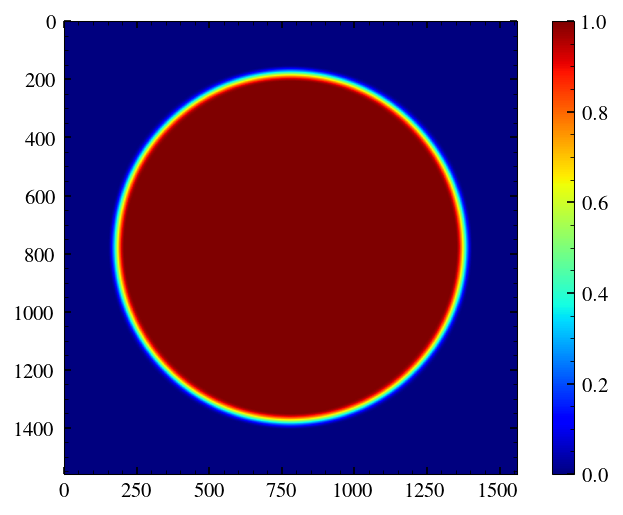

In [115]:
#mask
mask_circular = ksz_4pt_flatsky_tools.get_circular_mask(ny, nx, angres_am = reso_arcmin, circular_mask_deg = 5.)
imshow(mask_circular); colorbar(); show()

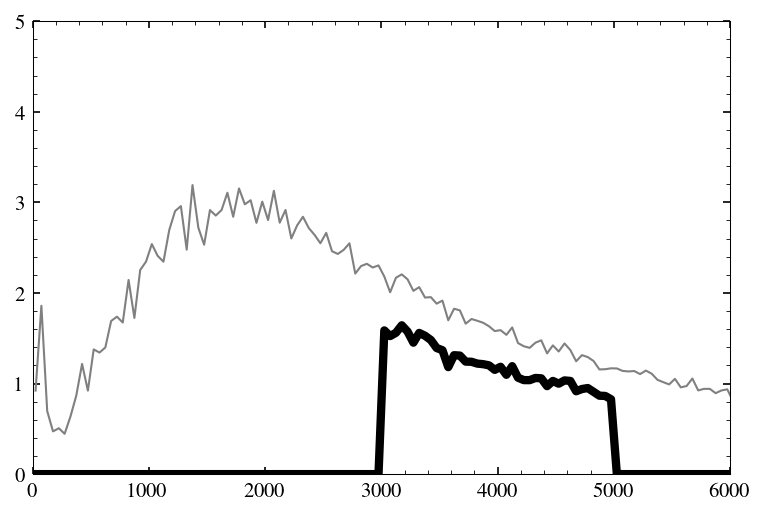

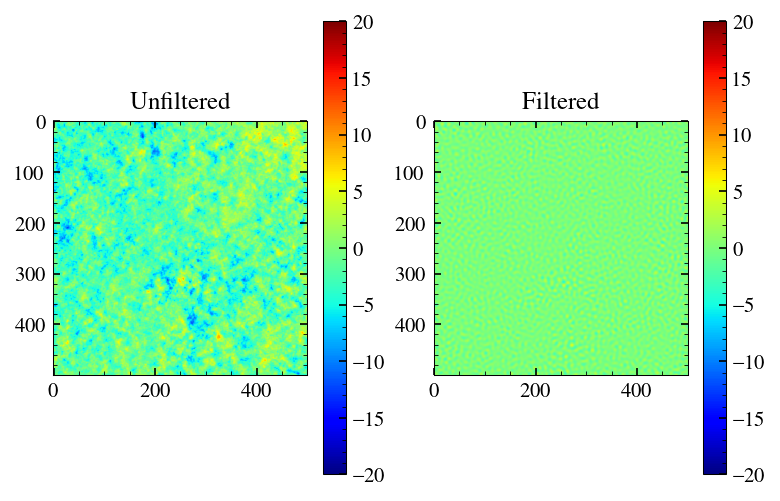

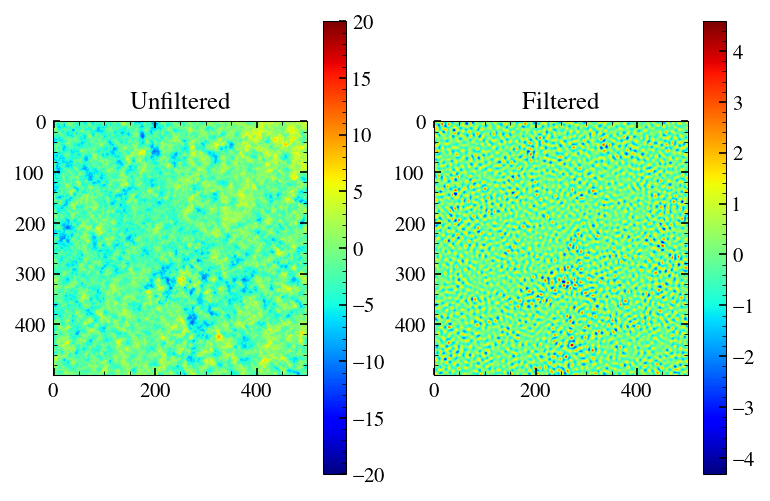

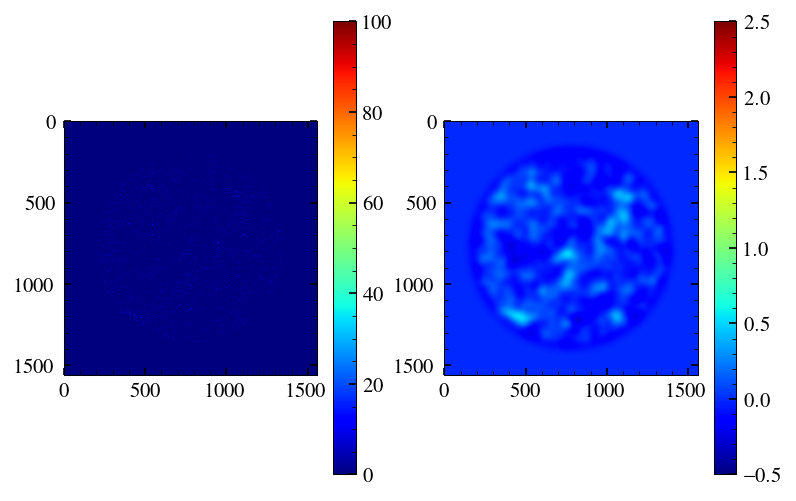

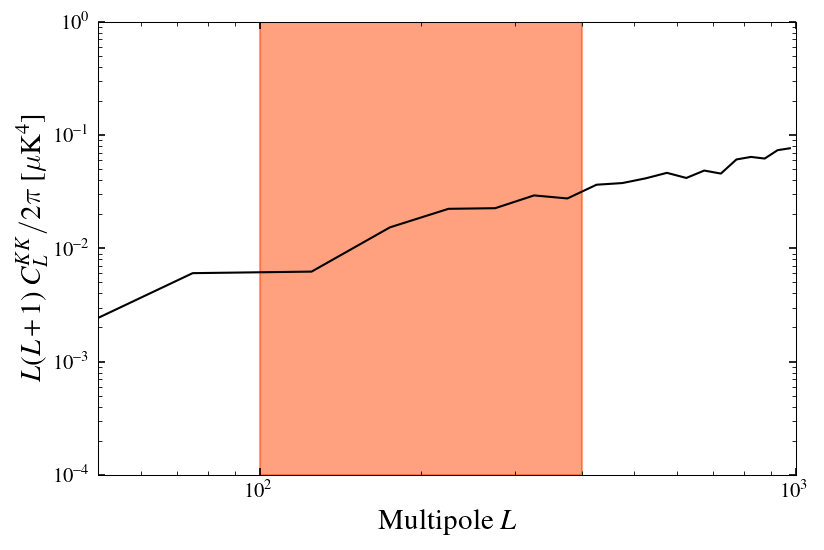

SystemExit: 

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3449: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [117]:
#loop over map and get the 4-pt
for mapname in maplist:

    ##########################################################################################
    #read map
    tmap = np.load( mapname, allow_pickle = True )# * 1e3
    tmap_unfil = np.copy( tmap )
    ##########################################################################################
    ksz_4pt_dict = {}
    for filter_lmin_lmax in filter_lmin_lmax_arr:

        lmin_for_filter, lmax_for_filter = filter_lmin_lmax
        
        #get filter
        wl_1d, wl_2D = ksz_4pt_flatsky_tools.get_filter(els, lmin_for_filter = lmin_for_filter, lmax_for_filter = lmax_for_filter, mapparams = mapparams)
        '''
        if (lmax_for_filter, lmax_for_filter) != (lmax_for_filter2, lmax_for_filter2):
            wl2_1d, wl2_2D = ksz_4pt_flatsky_tools.get_filter(els, lmin_for_filter = lmin_for_filter2, lmax_for_filter = lmax_for_filter2, mapparams = mapparams)
        '''
        
        if show_plot:
            clf()        
            plot(els, wl_1d); xlabel(r'Multipole $\ell$', fontsize = fsval); ylabel(r'Filter $w_{\ell}$', fontsize = fsval); 
            title(r'Filter $\ell \in [%g, %g]$' %(lmin_for_filter, lmax_for_filter), fontsize = fsval)
            show()

            clf()
            axlim = 6000.
            subplot(111); imshow( np.fft.fftshift(wl_2D), extent = [np.min(lx), np.max(lx), np.min(ly), np.max(ly)]); colorbar(); 
            xlabel(r'$\ell_{x}$', fontsize = fsval); ylabel(r'$\ell_{y}$', fontsize = fsval); 
            title(r'Filter $\ell \in [%g, %g]$' %(lmin_for_filter, lmax_for_filter), fontsize = fsval-4)
            xlim(-axlim, axlim); ylim(-axlim, axlim); 
            

        ##########################################################################################
        #filter maps
        tmap1 = np.fft.ifft2( np.fft.fft2( tmap * mask_circular ) * wl_2D ).real
        if (0):##(lmax_for_filter, lmax_for_filter) != (lmax_for_filter2, lmax_for_filter2):
            tmap2 = np.fft.ifft2( np.fft.fft2( tmap * mask_circular ) * w2_2D ).real
        else:
            tmap2 = np.copy( tmap1 )

        #get power spectrum
        el_, cl_m1_unfiltered = ksz_4pt_flatsky_tools.map2cl(mapparams, tmap_unfil, binsize = binsize, maxbin = lmax, mask = mask_circular)
        el_, cl_m1 = ksz_4pt_flatsky_tools.map2cl(mapparams, tmap1, binsize = binsize, maxbin = lmax, mask = mask_circular)
            
        if (1):#show_plot:


            '''
            if (lmax_for_filter, lmax_for_filter) != (lmax_for_filter2, lmax_for_filter2): #20231109
                el_, cl_m2 = ksz_4pt_flatsky_tools.map2cl(mapparams, tmap2, binsize = binsize, maxbin = lmax, mask = mask_circular)
            '''

            clf()
            ax = subplot(111)#, yscale='log')
            dl_fac = el_ * (el_+1)/2/np.pi
            plot(el_, dl_fac * cl_m1_unfiltered, color = 'gray')
            plot(el_, dl_fac * cl_m1, color = 'black', lw = 4.)
            '''
            if (lmax_for_filter, lmax_for_filter) != (lmax_for_filter2, lmax_for_filter2): #20231109
                plot(el_, dl_fac * cl_m2, color = 'red')
            '''
            xlim(0., 6000.); ylim(0., 5.)
            show(); ##sys.exit()

            clf()
            x1,x2, y1, y2 = 500, 1000, 500,1000
            vmin, vmax = -20., 20.
            subplot(121); imshow( tmap_unfil[x1:x2, y1:y2], vmin = vmin, vmax =vmax ); colorbar();  title(r'Unfiltered'); #unfiltered
            subplot(122); imshow( tmap1[x1:x2, y1:y2], vmin = vmin, vmax = vmax ); colorbar();  title(r'Filtered'); #filtered with w1_2D
            show()
            if (lmax_for_filter, lmax_for_filter) != (lmax_for_filter2, lmax_for_filter2): #20231109
                subplot(121); imshow( tmap_unfil[x1:x2, y1:y2], vmin = vmin, vmax = vmax ); colorbar(); title(r'Unfiltered');  #unfiltered
                subplot(122); imshow( tmap2[x1:x2, y1:y2]); colorbar(); title(r'Filtered');  #filtered with w2_2D
                show()
            #sys.exit()                
        ##########################################################################################

        ##########################################################################################
        #get bigK and power spectrum
        big_k_m1, mask_mod, el_, cl_big_k_m1 = ksz_4pt_flatsky_tools.get_4pt_flatsky(tmap1, smap2 = tmap2, mask = mask_circular, angres_am = reso_arcmin)#, add_new_mask_for_big_K = add_new_mask_for_big_K)        

        #smoothed with Gaussian beam
        big_k_m1_smoothed = np.fft.ifft2( np.fft.fft2(big_k_m1) * bl_2D_for_smoothing).real
        
        ksz_4pt_dict[filter_lmin_lmax] = [big_k_m1_smoothed, el_, cl_big_k_m1, el_2pt, cl_m1]

        if (1):##show_plot:
            subplot(121); imshow( big_k_m1, vmin = 0, vmax =100.); colorbar(); 
            subplot(122); imshow( big_k_m1_smoothed, vmin = -0.5, vmax = 2.5); colorbar(); 
            show()
        
            clf()
            dlfac_str = 'elsq'
            #dlfac_str = 'el'
            if dlfac_str == 'elsq':
                yscaleval = 'log'
                ylabval = r'$L(L+1)\ C_{L}^{KK}/2\pi$ [$\mu$K$^{4}$]'
                ymin, ymax = 1e-4, 1.
                dl_fac = el_ * (el_+1)/2/np.pi
            elif dlfac_str == 'el':
                yscaleval = None
                ymin, ymax = -1e-3, 1e-3
                ylabval = r'$L C_{L}^{KK}$ [$\mu$K$^{4}$]'
                dl_fac = el_

            clf()
            ax = subplot(111, yscale = 'log', xscale='log')
            plot(el_, dl_fac * cl_big_k_m1, color = 'black')
            xlim(50., 1000.); ylim(ymin, ymax)
            xlabel(r'Multipole $L$', fontsize = fsval)
            ylabel(ylabval, fontsize = fsval)
            axvspan(100., 400., color = 'orangered', alpha = 0.5)
            show(); sys.exit()     
        ##########################################################################################
    print(ksz_4pt_dict.keys())
    sys.exit()

0
1
2
3


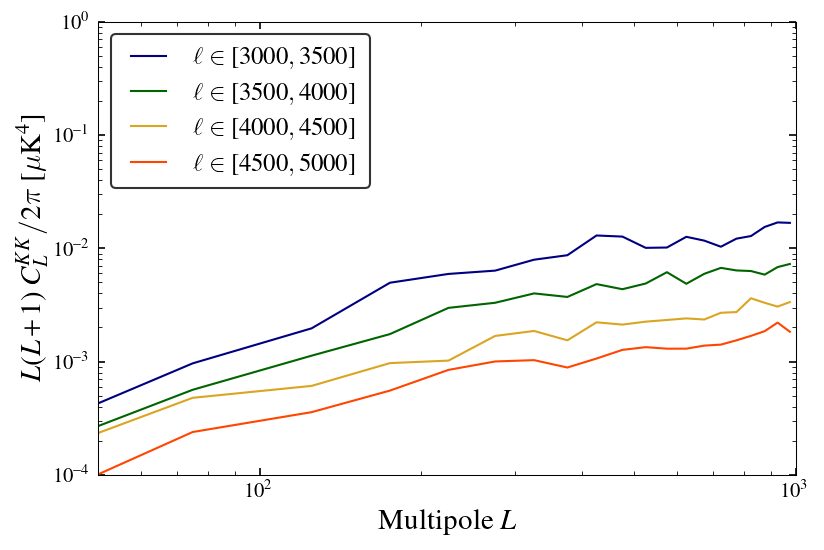

SystemExit: 

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3449: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [97]:
color_arr = ['navy', 'darkgreen', 'goldenrod', 'orangered', 'darkred']
dlfac_str = 'elsq'
#dlfac_str = 'el'
if dlfac_str == 'elsq':
    scaleval = 'log'
    ylabval = r'$L(L+1)\ C_{L}^{KK}/2\pi$ [$\mu$K$^{4}$]'
    ymin, ymax = 1e-4, 1.
elif dlfac_str == 'el':
    scaleval = None
    ymin, ymax = -1e-3, 1e-3
    ylabval = r'$L C_{L}^{KK}$ [$\mu$K$^{4}$]'
    dl_fac = el_

clf()
ax = subplot(111, yscale = scaleval, xscale= scaleval)
for filter_lmin_lmax_cntr, filter_lmin_lmax in enumerate( sorted(ksz_4pt_dict) ):
    print(filter_lmin_lmax_cntr)
    big_k_m1_smoothed, el_, cl_big_k_m1, el_2pt,  = ksz_4pt_dict[filter_lmin_lmax]
    if dlfac_str == 'elsq':
        dl_fac = el_ * (el_+1)/2/np.pi
    elif dlfac_str == 'el':
        dl_fac = el_
    plot(el_, dl_fac * cl_big_k_m1, color = color_arr[filter_lmin_lmax_cntr], label = r'$\ell \in [%g, %g]$' %(filter_lmin_lmax[0], filter_lmin_lmax[1]))
    
xlim(50., 1000.); ylim(ymin, ymax)
xlabel(r'Multipole $L$', fontsize = fsval)
ylabel(ylabval, fontsize = fsval)
legend(loc = 2, fontsize = fsval - 2)
#axvspan(100., 400., color = 'orangered', alpha = 0.5)
show(); sys.exit()   